# Loop Hydrodynamics: Intermediate-frequency Nanoflares

In [1]:
import os
import sys
import subprocess
import multiprocessing

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.interfaces import EbtelInterface

sys.path.append('../../scripts')
from constrained_heating_model import CustomHeatingModel

%matplotlib inline

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [3]:
heating_options = {
    'duration': 200.0,
    'duration_rise': 100.0,
    'duration_decay': 100.0,
    'stress_level': 0.3,
    'power_law_slope': -2.5,
    'frequency_parameter': 1.
}

In [4]:
heating_model = CustomHeatingModel(heating_options)

In [5]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [6]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/hydro_results/')

In [7]:
heating_model.constrain_distribution(field,tolerance=1e-2,total_ar_flux=1e7,sigma_increase=0.1,sigma_decrease=1e-6)

In [8]:
field.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

In [9]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [10]:
pool = multiprocessing.Pool()

In [11]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [12]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/loop_parameters.h5'
                           )

FloatProgress(value=0.0)

Text(0.5,0,'$t$ [s]')

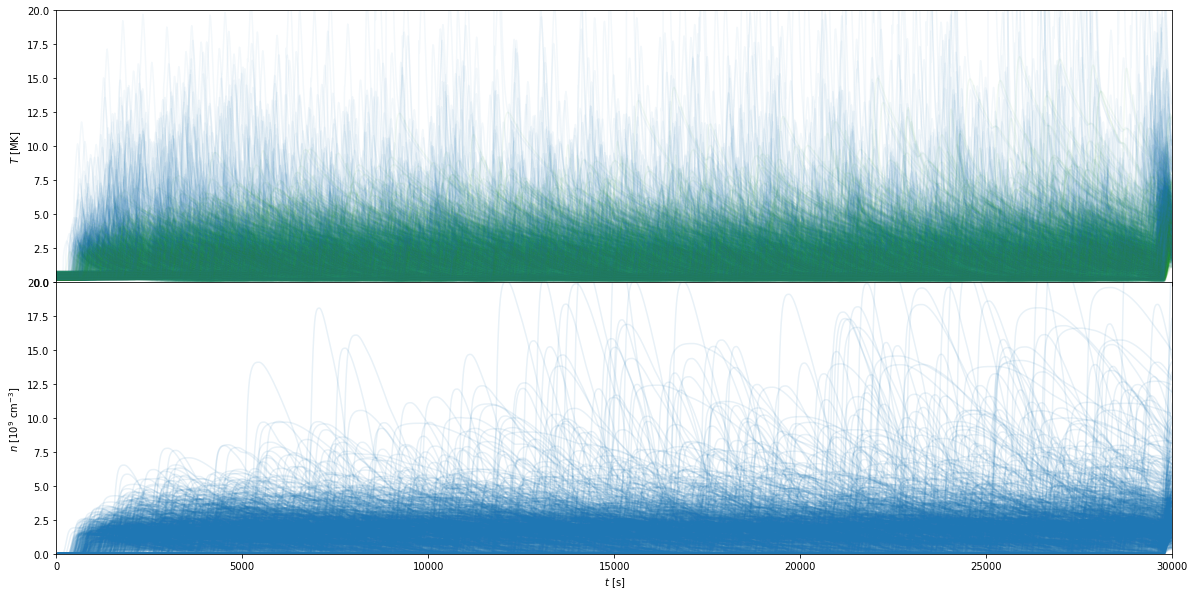

In [13]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.05)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(0,base_config['total_time'])
axes[0].set_ylim(0,20)
axes[1].set_ylim(0,20)
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [20]:
field.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint')